# Train a deep CNN on XPS data on local machine

In this notebook, we will train a deep convolutional network on iron XPS spectra using the local CPU/GPU.

## Setup

In [1]:
# Standard imports
import os
import shelve
import numpy as np
import json
import csv
import datetime
import h5py
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '0'
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Import tensorflow modules
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger

# Import custom classes
from classifier_cpu import Classifier
from models import CustomModel, CustomModelSimpleCNN, CustomModelCNN, CustomModelMLP
from utils import TrainingGraphs, SpectrumFigure, Report

## Setting up the parameters & folder structure

In [2]:
np.random.seed(502)
time =  datetime.datetime.now().strftime("%Y%m%d_%Hh%Mm")
model_type = 'CNN_simple'
model_name = 'Fe_single_4_classes_CNN_simple'

input_filepath = r'C:\Users\pielsticker\Simulations\20200605_iron_single.h5'                    
label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

classifier = Classifier(time = time,
                        model_type = model_type,
                        model_name = model_name,
                        labels = label_values)

## Load and inspect the data

Data was loaded!
Total no. of samples: 1000
No. of training samples: 640
No. of validation samples: 160
No. of test samples: 200
Shape of each sample : 1121 features (X) + 4 labels (y)


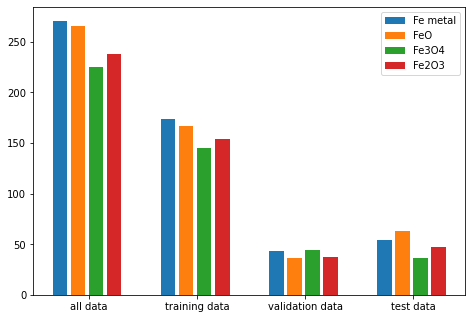

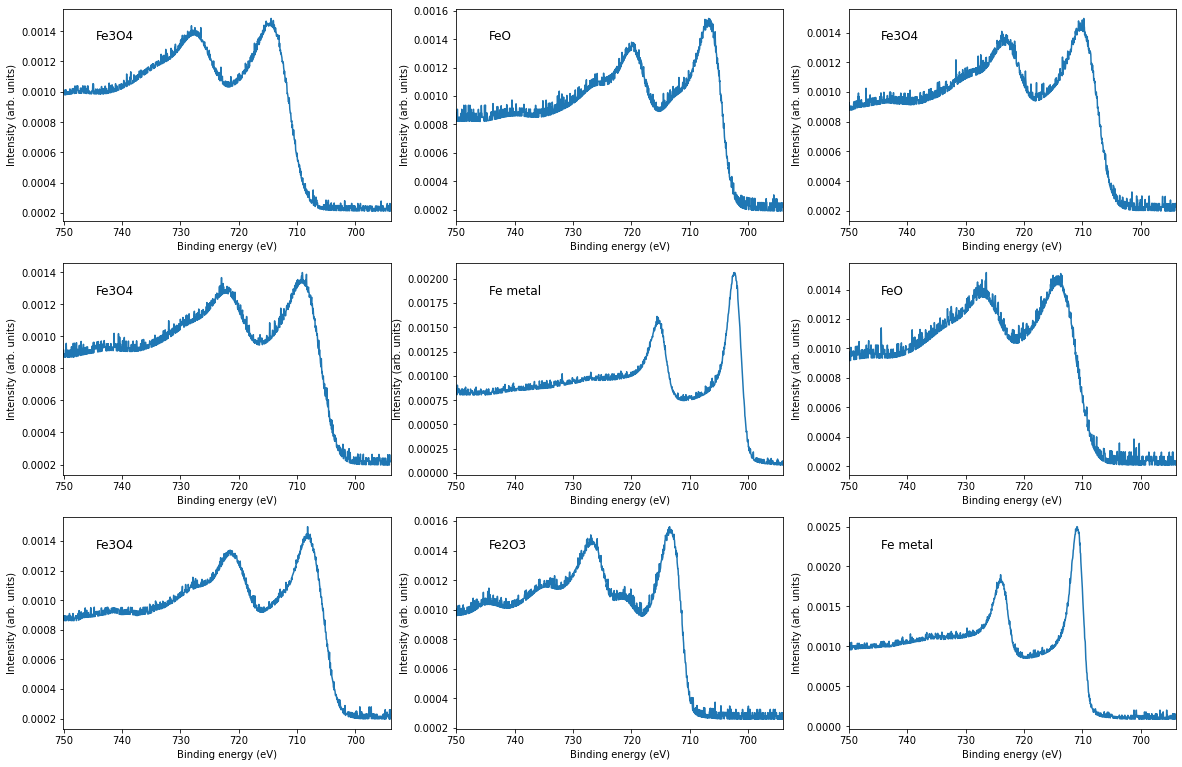

In [3]:
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 1000

X_train, X_val, X_test, y_train, y_val, y_test = classifier.load_data_preprocess(input_filepath = input_filepath,
                                                                                 no_of_examples = no_of_examples,
                                                                                 train_test_split = train_test_split,
                                                                                 train_val_split = train_val_split)
# Check how the examples are distirbuted across the classes.
class_distribution = classifier.check_class_distribution()
classifier.plot_class_distribution()
classifier.plot_random(no_of_spectra = 9)           

### Build the model

Model: "Custom_CNN_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1113, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1105, 64)          18496     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 552, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 552, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 35328)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4522112   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)         

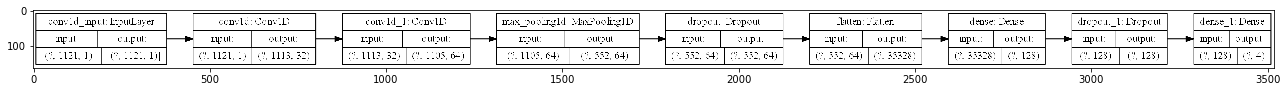

In [4]:
classifier.build_model()
classifier.summary()
classifier.save_and_print_model_image()

### Training

In [5]:
epochs = 2
batch_size = 32

hist = classifier.train(checkpoint = True,
                        early_stopping = False,
                        tb_log = True, 
                        csv_log = True,
                        epochs = epochs, 
                        batch_size = batch_size)

Train on 640 samples, validate on 160 samples
Epoch 1/2
640/640 [==============================] - 10s 16ms/sample - loss: 1.3863 - accuracy: 0.2766 - val_loss: 1.3863 - val_accuracy: 0.2250
Epoch 2/2
640/640 [==============================] - 6s 9ms/sample - loss: 1.3862 - accuracy: 0.2828 - val_loss: 1.3863 - val_accuracy: 0.2250
Training done!


### Evaluation

In [6]:
score = classifier.evaluate()
test_loss, test_accuracy = score[0], score[1]

200/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Prediction

In [7]:
pred_train, pred_test = classifier.predict()
pred_train_classes, pred_test_classes = classifier.predict_classes()

640/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

200/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Saving data

In [8]:
classifier.save_model()
classifier.shelve_results(full = False)  

INFO:tensorflow:Assets written to: C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\\saved_models\20200617_11h51m_Fe_single_4_classes_CNN_simple\assets
Saved model and hyperparameters.


### Graphs

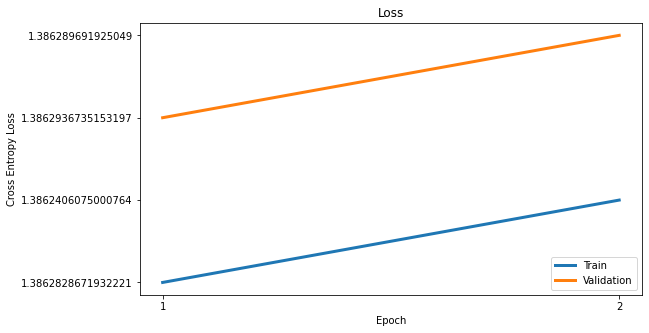

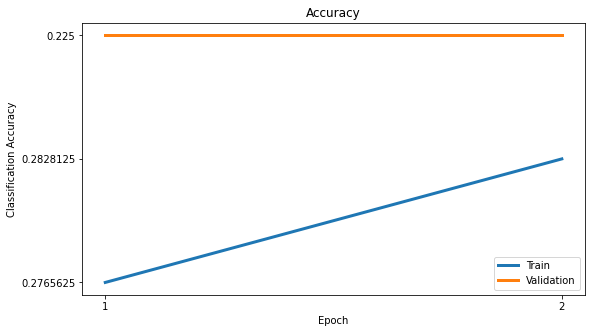

In [11]:
graph = TrainingGraphs(classifier.history,
                        classifier.model_name,
                        classifier.time) 

### Report

In [12]:
dir_name = classifier.time + '_' + classifier.model_name
rep = Report(dir_name)  
rep.write()   

Report saved!


### Continue training 

Loaded model from disk.
Train on 640 samples, validate on 160 samples
Epoch 3/4
640/640 [==============================] - 8s 12ms/sample - loss: 1.3862 - accuracy: 0.2828 - val_loss: 1.3863 - val_accuracy: 0.3187
Epoch 4/4
640/640 [==============================] - 7s 11ms/sample - loss: 1.3861 - accuracy: 0.2812 - val_loss: 1.3863 - val_accuracy: 0.2688
Training done!
200/1 [============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

200/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

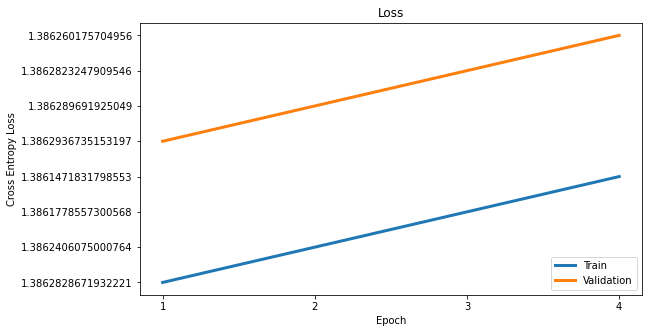

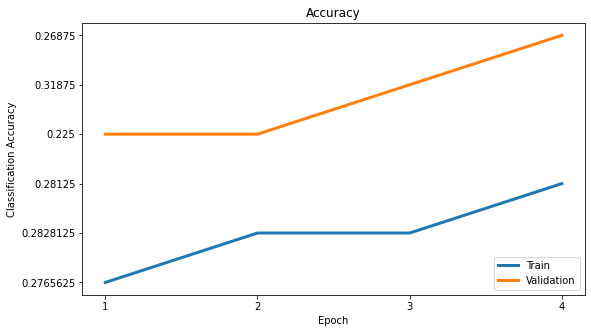

INFO:tensorflow:Assets written to: C:\Users\pielsticker\Lukas\MPI-CEC\Projects\xpsdeeplearning\\saved_models\20200617_11h51m_Fe_single_4_classes_CNN_simple\assets
Saved model and hyperparameters.
Report saved!


In [13]:
# Reload and train for more epochs
classifier.load_model(from_path = False)

epochs = 2
batch_size = 32
hist = classifier.train(checkpoint = True,
                        early_stopping = False,
                        tb_log = True, 
                        csv_log = True,
                        epochs = epochs, 
                        batch_size = batch_size)
score = classifier.evaluate()
test_loss, test_accuracy = score[0], score[1]

pred_train, pred_test = classifier.predict()
pred_train_classes, pred_test_classes = classifier.predict_classes()

graphs = TrainingGraphs(hist,classifier.model_name, classifier.time)
classifier.save_model()
classifier.shelve_results(full = False)  

dir_name = classifier.time + '_' + classifier.model_name
rep = Report(dir_name)  
rep.write()  
